In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4)
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from os import listdir

In [3]:
def anim(data, interval=50):

    # number of frames:
    nt = data.shape[0]
    
    fig, ax = plt.subplots()

    # initialize plot at first frame
    im = ax.imshow(data[0], cmap='rainbow')

    # animation function to be called at each frame n
    def animate(n):
        im.set_array(data[n])
        return [im]
    
    # call the animator, blit=True means only re-draw the parts that have changed, interval is in ms (between each frame)
    anim = animation.FuncAnimation(fig, animate, frames=np.arange(nt),
                                  blit=True, interval=interval)
    return anim, ax

In [5]:
def dp_space_cent2(p, dx, dy, u, v, D):
    """Spatial derivatives (r.h.s. of the equation)"""

    dp = np.zeros_like(p)

    for ax, d, c in zip([0,1], [dx, dy], [u, v]):
        pp = np.roll(p,1,axis=ax)
        pm = np.roll(p,-1,axis=ax)

        dp += D / d**2 * (pp - 2*p + pm)
        dp -= 1/ (2*d) * c * (pp - pm)

    return dp

dp_space = dp_space_cent2

def advance_RK3(p, dx, dy, u, v, D, dt):
    k1 = dp_space(p, dx, dy, u, v, D)
    k2 = dp_space(p + dt /2 * k1, dx, dy, u, v, D)
    k3 = dp_space(p - dt*k1 + 2*dt*k2, dx, dy, u, v, D)
    pnew = p + dt * (k1/6 + 2*k2/3 + k3/6)
    # apply BCs:
    """
    pnew[:,0] = 1
    pnew[:,-1] = 2
    pnew[0,:] = pnew[1,:]
    pnew[-1,:] = pnew[-2,:]
    """
    return pnew

Here, $\phi$ represents the pressure $P_{i,j}$, and 
$$
b_{i,j} = \Delta x^2 \frac{\rho_0}{\Delta t} \left(\frac{\partial u^{**}}{\partial x} +  \frac{\partial v^{**}}{\partial y} \right)_{i,j}
$$

In [6]:
%reload_ext autoreload
%aimport poisson_solver
from poisson_solver import SOR_solver

In [7]:
def compute_P(u, v, dx, dt, rho, Pprev=None):
    
    U = np.zeros((2, *u.shape))
    U[0] = u
    U[1] = v
    dU = np.zeros_like(U)
    for ax in [0,1]:
        Up = np.roll(U[ax], 1,axis=ax)
        Um = np.roll(U[ax],-1,axis=ax)
        dU[ax] = (Up - Um) / (2 * dx)

    b = dx**2 * rho / dt * (dU[0] + dU[1])
    
    return SOR_solver(b, Pprev=Pprev, w=1.5, maxit=100)

In [9]:
%autoreload 1
N,M = 40, 50
u = np.zeros((N,M))
v = np.ones((N,M)) 
P = np.zeros((N,M))


u[:N//4,:] = 1

dx = 1e-1
dt = 5e-3

NT = 1000

U = np.zeros((NT, M, N))

sigma = np.zeros(NT) # metric for stability analysis

#nu = 15e-6   # viscosity [m²s⁻¹]
nu = 1
rho = 1.1614 # density [kg/m⁻³]


for n in range(NT):
    U[n] = u.T
    
    # Note: we should alternate sequence u,v after each step
    
    # first step (advection, set D=0)
    u = advance_RK3(u, dx, dx, u, v, 0, dt)
    v = advance_RK3(v, dx, dx, u, v, 0, dt)
    
    # second step (diffusion, set D=nu, u=0=V in the advective part)
    u = advance_RK3(u, dx, dx, 0, 0, nu, dt)
    v = advance_RK3(v, dx, dx, 0, 0, nu, dt)
    
    # solve P
    #P = compute_P(u, v, dx, dt, rho, Pprev=P)
    P = np.zeros((N,M))
    
    # compute derivates of P along x and y:
    dP = np.zeros((2, *P.shape))
    for ax in [0,1]:
        Pp = np.roll(P,1,axis=ax)
        Pm = np.roll(P,-1,axis=ax)
        dP[ax] = (Pp - Pm) / (2 * dx)
    
    # third step (P)
    u = u - dt / rho * dP[0]
    v = v - dt / rho * dP[1]   
    
    
    sigma[n] = np.sum(u**2 + v**2)
    

<IPython.core.display.Javascript object>


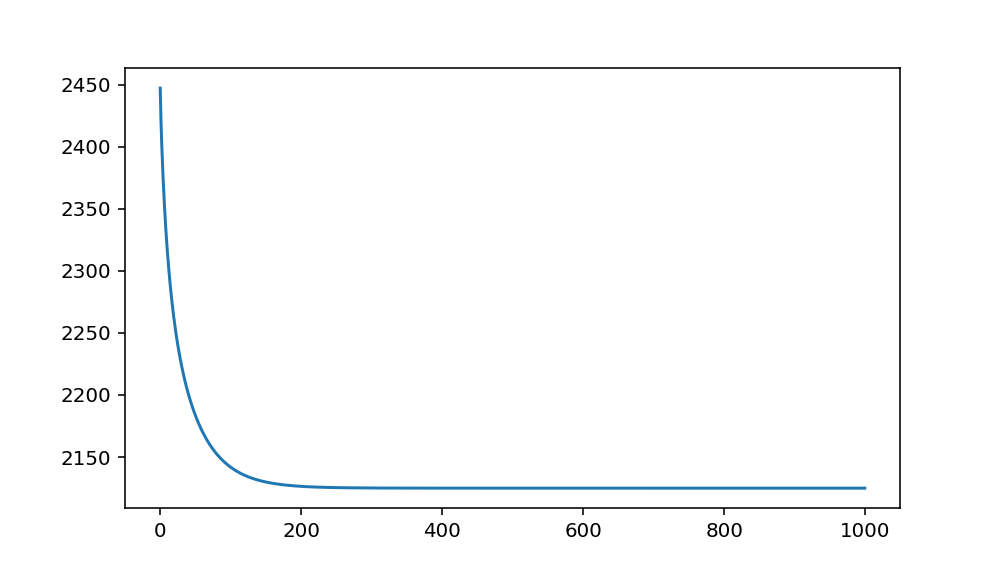

In [10]:
fig, ax = plt.subplots()
ax.plot(sigma)

<IPython.core.display.Javascript object>


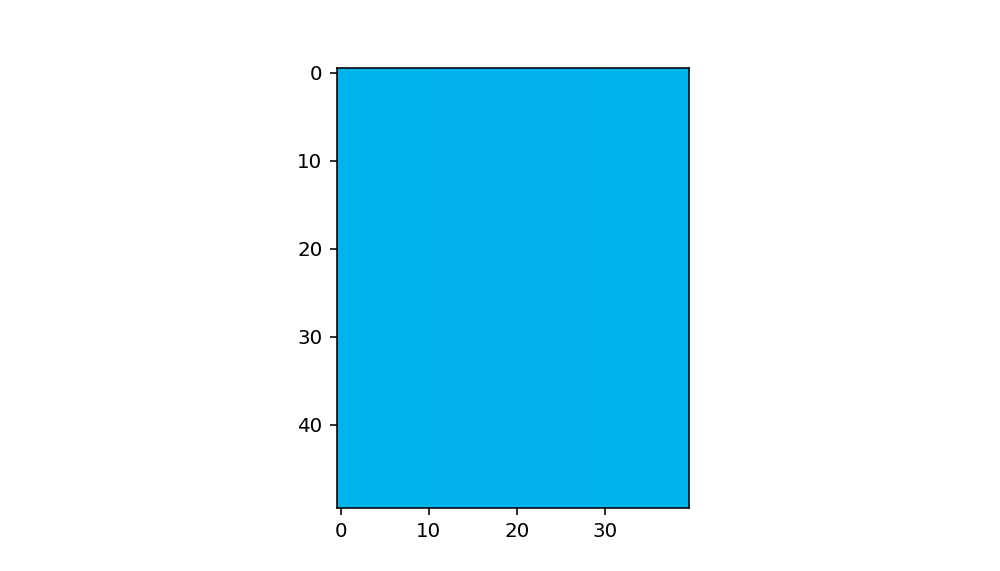

(<matplotlib.animation.FuncAnimation at 0x7f45e1fb3d60>, <AxesSubplot:>)

In [12]:
anim(U, interval=5)